# Pronóstico de dedores morosos

**John González**

**1 de marzo de 2021**

**Objetivo**: Pronosticar los deudores morosos a partir de información de clientes una entidad financiera.

**Metodología**: Se realizará varios modelos de pronóstico y se evaluará su desempeño mediante diversas métricas.

___

## **04 - Parte 1**: Preparando los datos

## Importando paquetes

In [ ]:
!pip install sweetviz

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# https://drive.google.com/file/d/1SmyJelVI5rLYjowXdL3WWVgVo2Mwq4Xj/view?usp=sharing
url = 'https://drive.google.com/uc?id=1SmyJelVI5rLYjowXdL3WWVgVo2Mwq4Xj'
df = pd.read_csv(url)
df

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,10+ years,RENT,10.65%,5000,credit_card,36 months,B
1,Charged Off,30000.0,Source Verified,< 1 year,RENT,15.27%,2500,car,60 months,C
2,Fully Paid,12252.0,Not Verified,10+ years,RENT,15.96%,2400,small_business,36 months,C
3,Fully Paid,49200.0,Source Verified,10+ years,RENT,13.49%,10000,other,36 months,C
4,Fully Paid,80000.0,Source Verified,1 year,RENT,12.69%,3000,other,60 months,B
...,...,...,...,...,...,...,...,...,...,...
38700,Fully Paid,110000.0,Not Verified,4 years,MORTGAGE,8.07%,2500,home_improvement,36 months,A
38701,Fully Paid,18000.0,Not Verified,3 years,RENT,10.28%,8500,credit_card,36 months,C
38702,Fully Paid,100000.0,Not Verified,< 1 year,MORTGAGE,8.07%,5000,debt_consolidation,36 months,A
38703,Fully Paid,200000.0,Not Verified,< 1 year,MORTGAGE,7.43%,5000,other,36 months,A


## Revisión de datos y su tipo

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   loan_status          38705 non-null  object 
 1   annual_inc           38705 non-null  float64
 2   verification_status  38705 non-null  object 
 3   emp_length           38705 non-null  object 
 4   home_ownership       38705 non-null  object 
 5   int_rate             38705 non-null  object 
 6   loan_amnt            38705 non-null  int64  
 7   purpose              38705 non-null  object 
 8   term                 38705 non-null  object 
 9   grade                38705 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.0+ MB


In [4]:
df['loan_status'] = df.loan_status.astype('category')
df['verification_status'] = df.verification_status.astype('category')
df['home_ownership'] = df.home_ownership.astype('category')
df['purpose'] = df.purpose.astype('category')
df['grade'] = df.grade.astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38705 entries, 0 to 38704
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   loan_status          38705 non-null  category
 1   annual_inc           38705 non-null  float64 
 2   verification_status  38705 non-null  category
 3   emp_length           38705 non-null  object  
 4   home_ownership       38705 non-null  category
 5   int_rate             38705 non-null  object  
 6   loan_amnt            38705 non-null  int64   
 7   purpose              38705 non-null  category
 8   term                 38705 non-null  object  
 9   grade                38705 non-null  category
dtypes: category(5), float64(1), int64(1), object(3)
memory usage: 1.7+ MB


In [7]:
def quite_months(x):
    '''
    Elimina la palabra months que se encuentre dentro de una columna
    '''
    x = x.split()      # divide donde encuentra espacio
    return int(x[0])   # toma el primer elemento y lo convierte en entero

df['term'] = df.term.apply(quite_months)

### **Problema 1**:
Elimine el símbolo de porcentaje en la variable `int_rate` y convierta la variable en flotante (`float`). Ayuda: Utilice la función `replace`. Ejemplo:

```
'hola soy john'.replace('john', 'el mejor')
```

Genera:
```
'hola soy el mejor'
```

**Bono**: Deje como numérico la variable `emp_length`

In [8]:
def quite_porcentaje(x):
    ''' 
    Se elimina el caracter % que se encuentre en los valores de la columna
    '''
    return float(x.replace('%', ''))

df['int_rate'] = df.int_rate.apply(quite_porcentaje)

In [9]:
def elimina_ultima_palabra(x):
    '''
    Elimina el ultimo caracter
    '''
    return ''.join(x.split()[:-1])           # Elimina última palabra del texto

df['emp_length'] = df.emp_length.apply(elimina_ultima_palabra)\
                     .replace({'10+':'11', '<1':'0'})\
                     .astype(int)

In [10]:
df

,loan_status,annual_inc,verification_status,emp_length,home_ownership,int_rate,loan_amnt,purpose,term,grade
0,Fully Paid,24000.0,Verified,11,RENT,10.65,5000,credit_card,36,B
1,Charged Off,30000.0,Source Verified,0,RENT,15.27,2500,car,60,C
2,Fully Paid,12252.0,Not Verified,11,RENT,15.96,2400,small_business,36,C
3,Fully Paid,49200.0,Source Verified,11,RENT,13.49,10000,other,36,C
4,Fully Paid,80000.0,Source Verified,1,RENT,12.69,3000,other,60,B
...,...,...,...,...,...,...,...,...,...,...
38700,Fully Paid,110000.0,Not Verified,4,MORTGAGE,8.07,2500,home_improvement,36,A
38701,Fully Paid,18000.0,Not Verified,3,RENT,10.28,8500,credit_card,36,C
38702,Fully Paid,100000.0,Not Verified,0,MORTGAGE,8.07,5000,debt_consolidation,36,A
38703,Fully Paid,200000.0,Not Verified,0,MORTGAGE,7.43,5000,other,36,A


<AxesSubplot:>

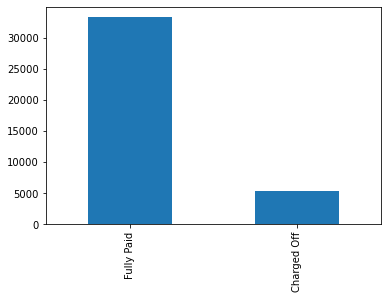

In [11]:
df.loan_status.value_counts().plot.bar()

In [12]:
list(df.loan_status.cat.categories)

['Charged Off', 'Fully Paid']

In [13]:
import sweetviz as sv
reporte = sv.compare_intra(df, df.loan_status == 'Charged Off', list(df.loan_status.cat.categories))

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.



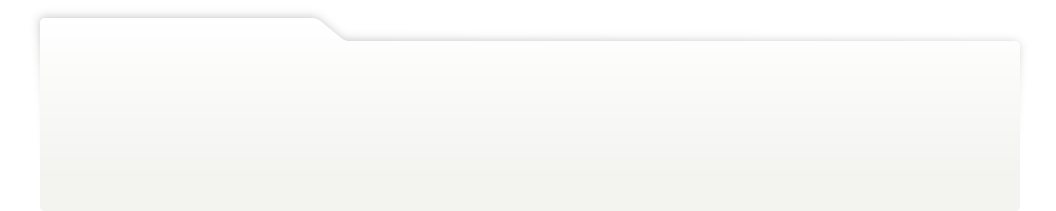
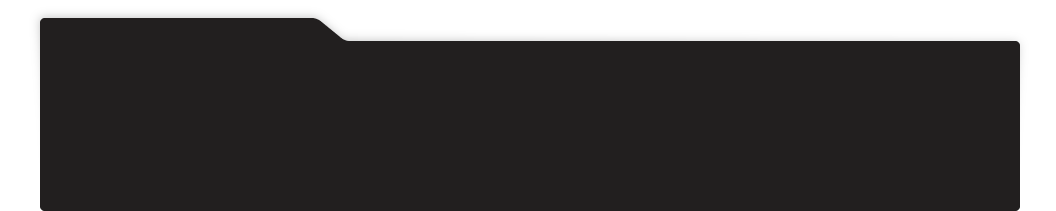
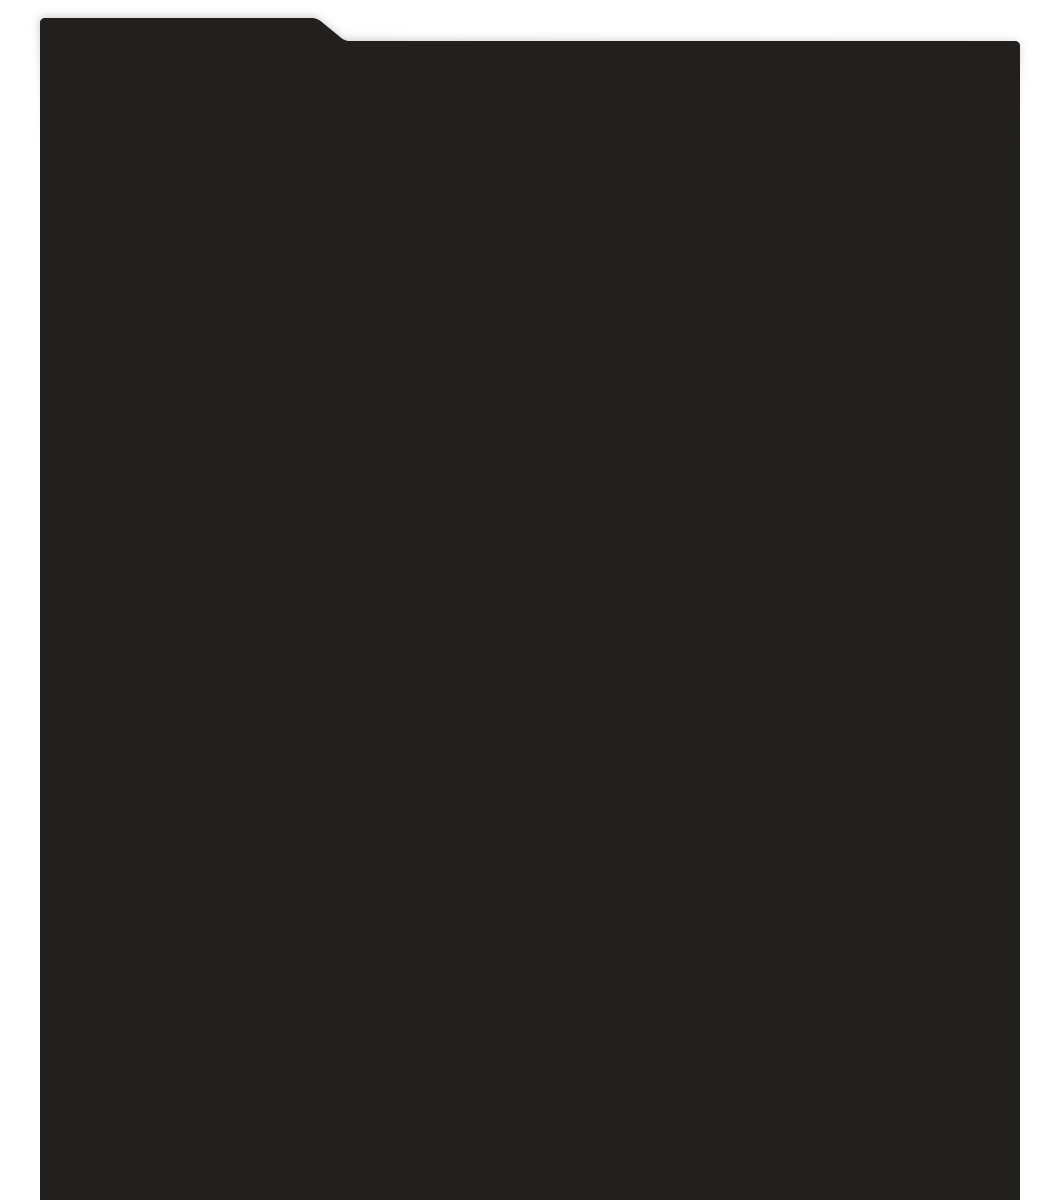
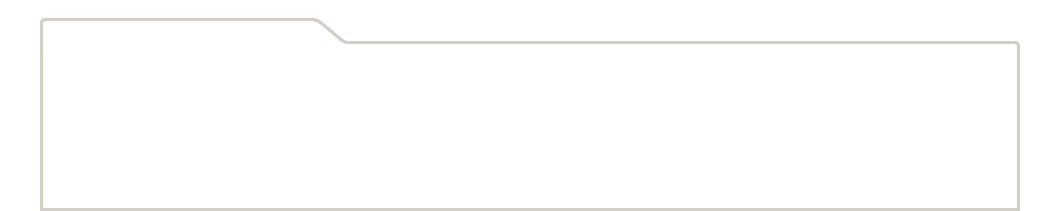
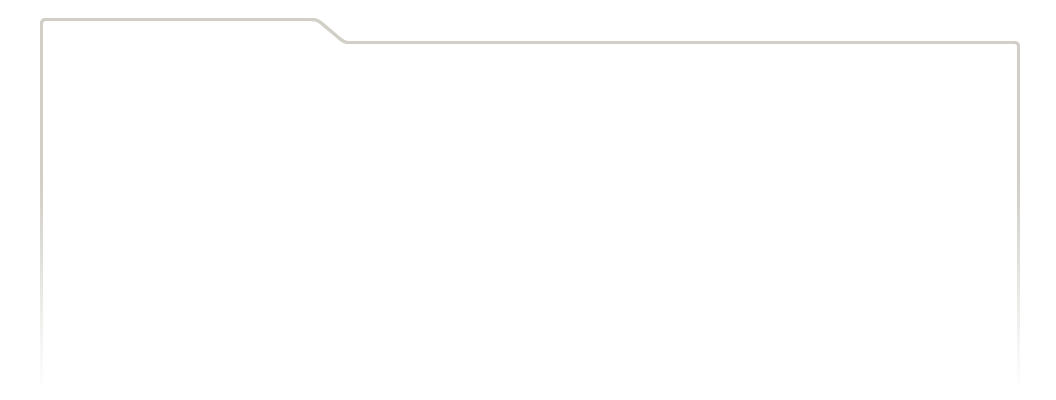
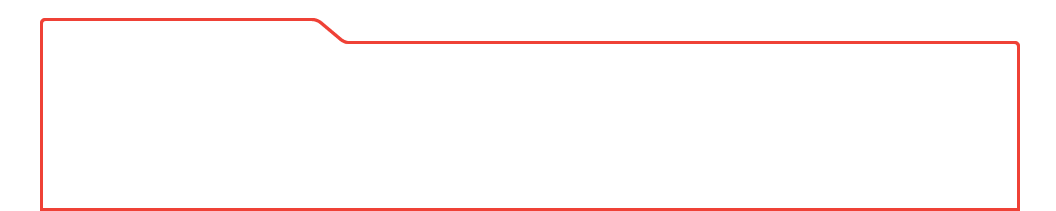
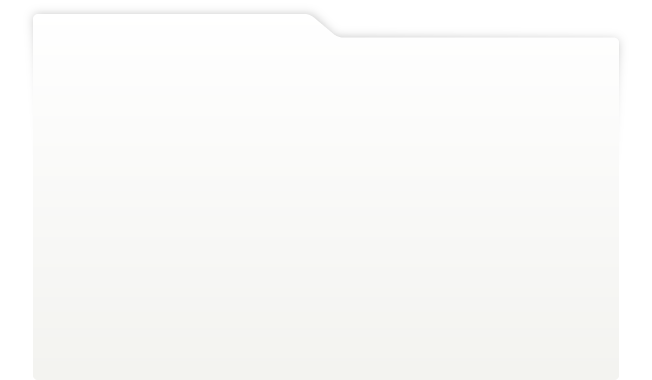
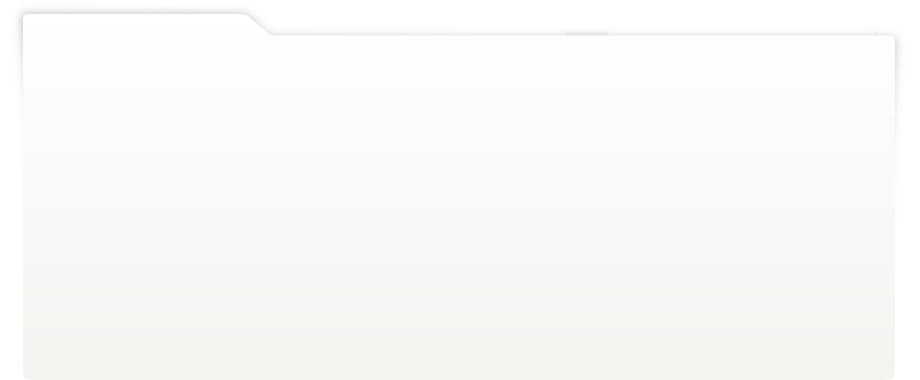
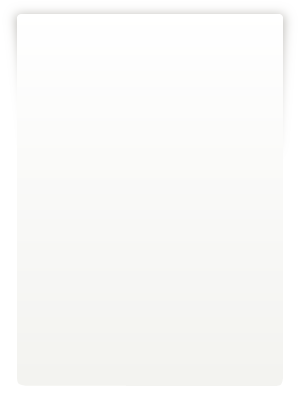
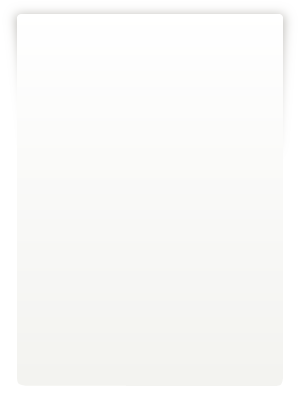
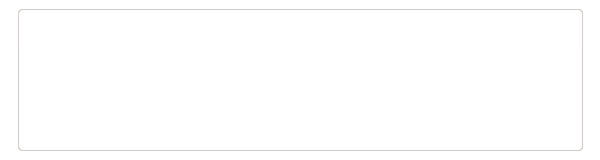
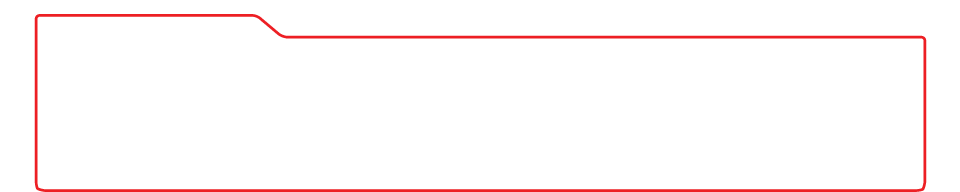
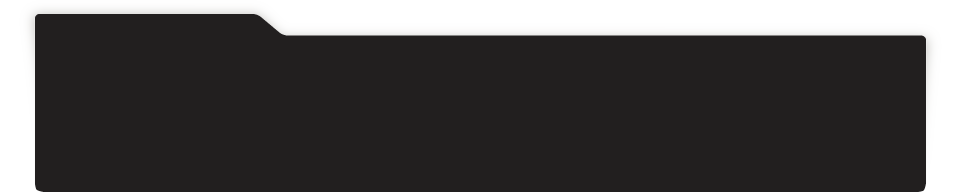
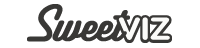
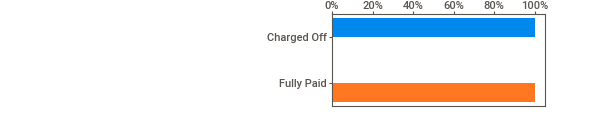
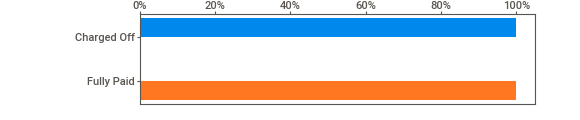
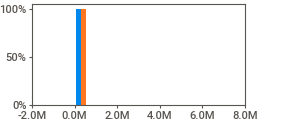
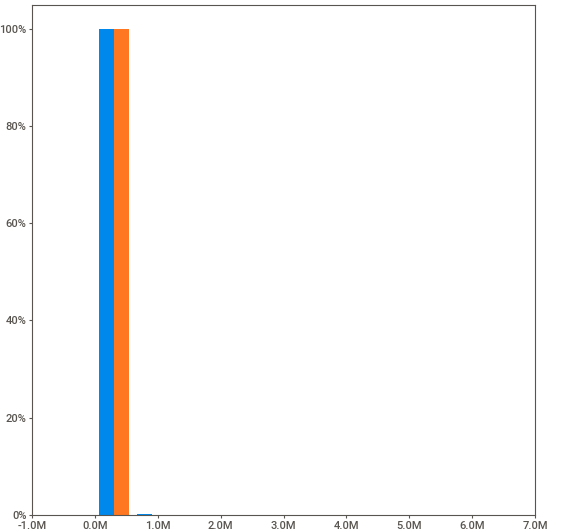
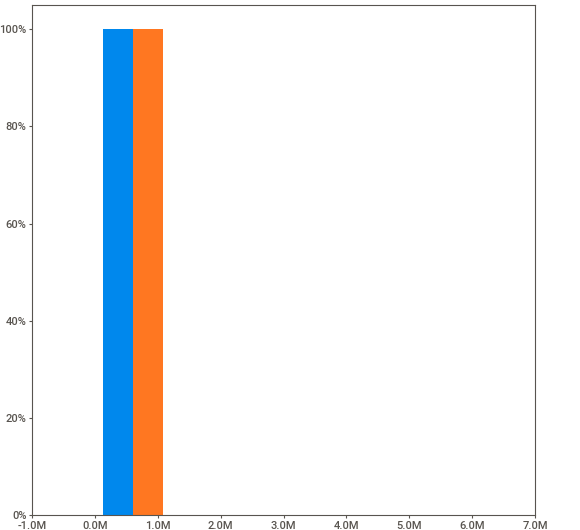
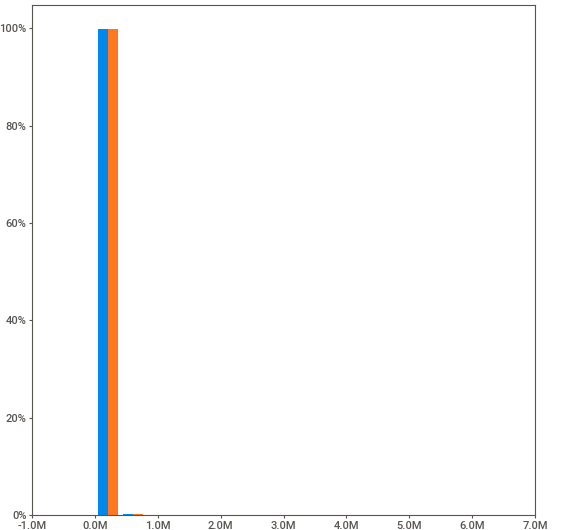
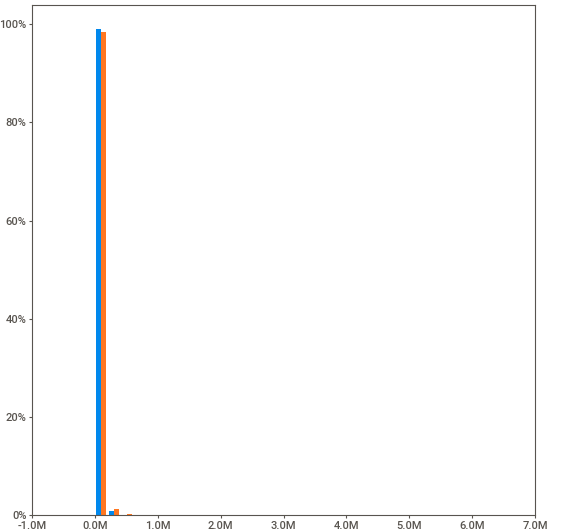
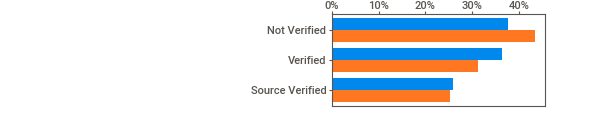
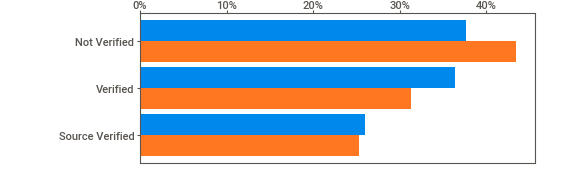
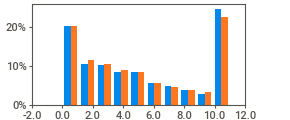
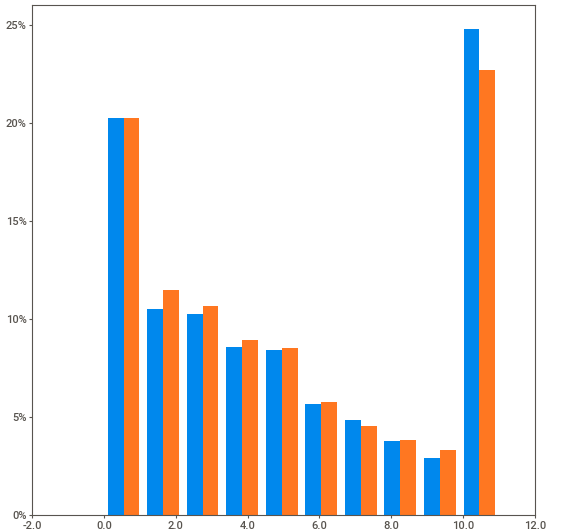
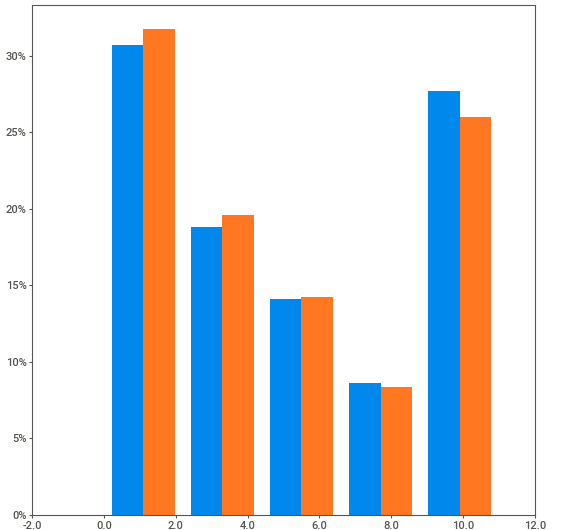
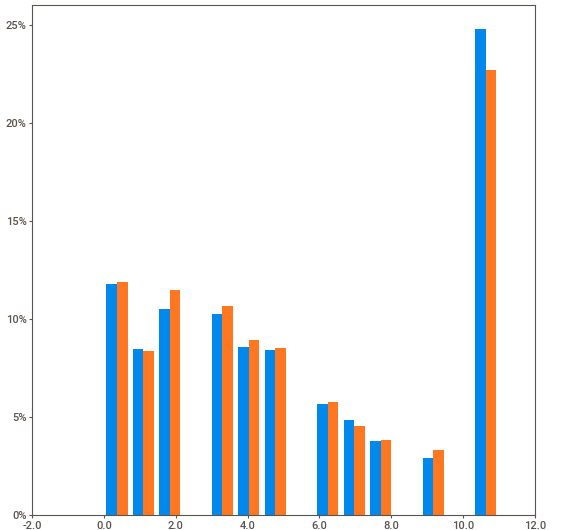
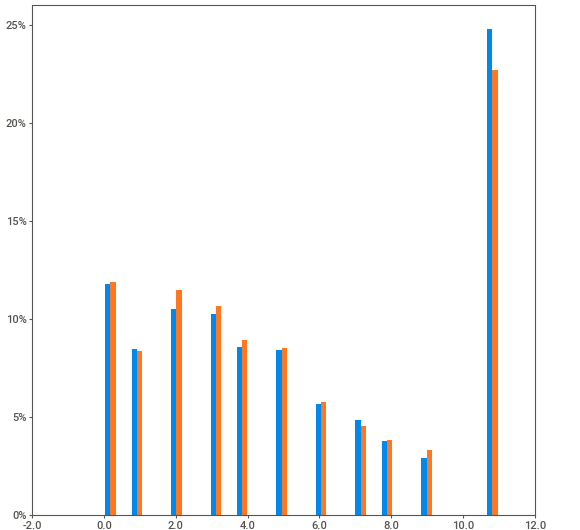
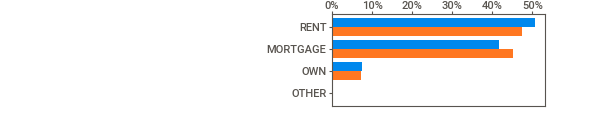
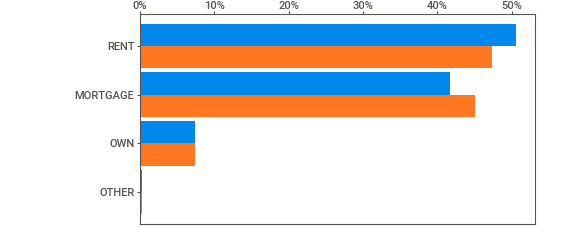
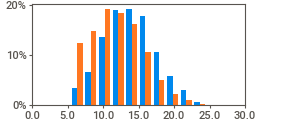
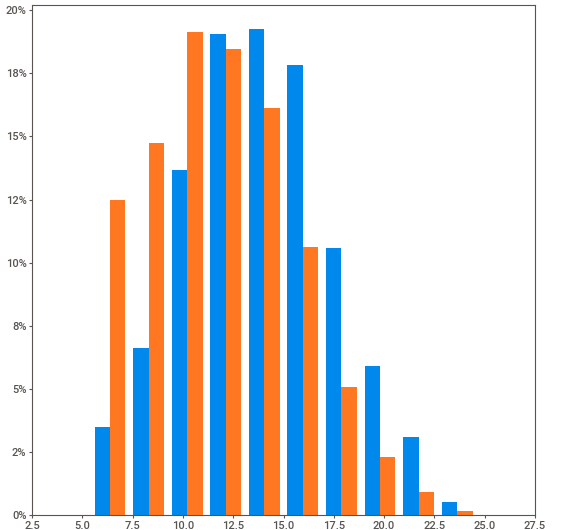
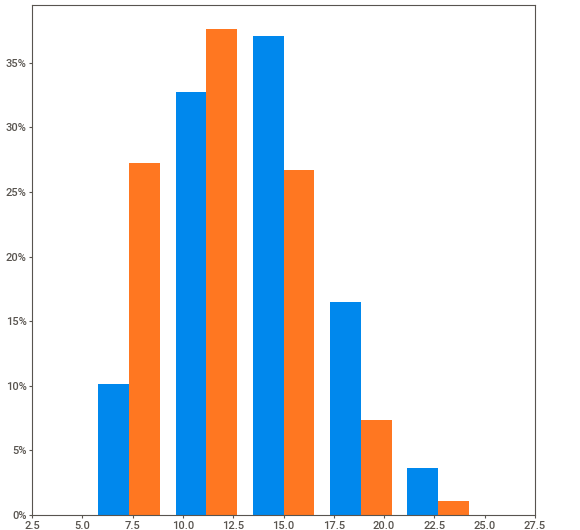
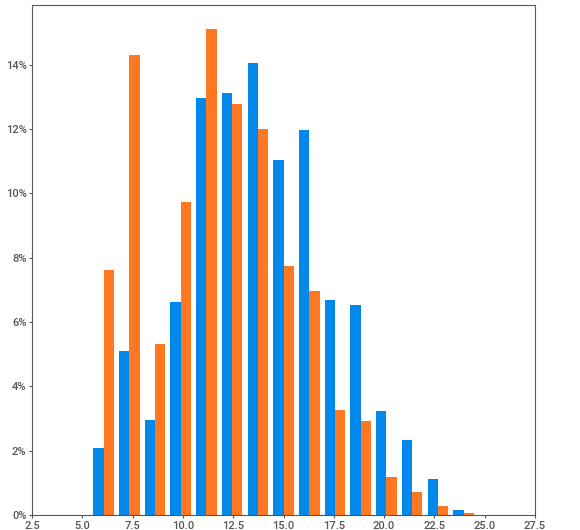
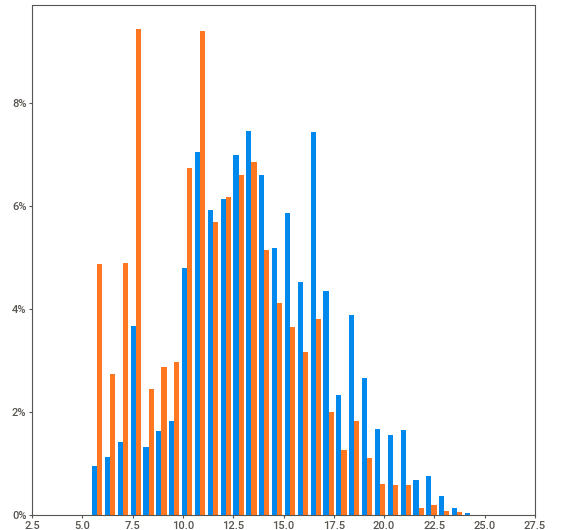
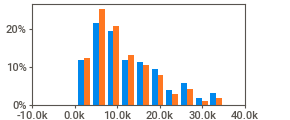
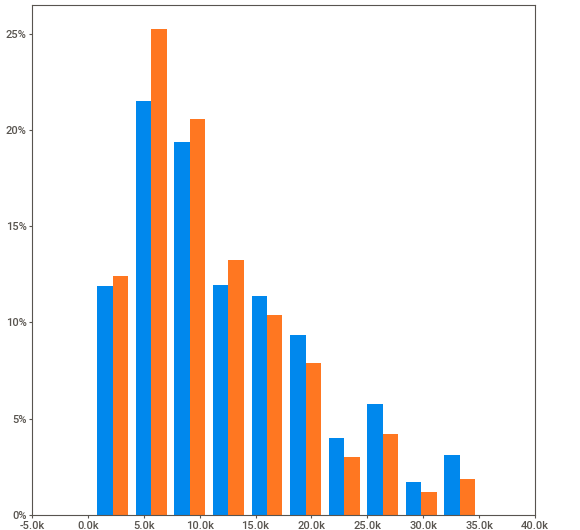
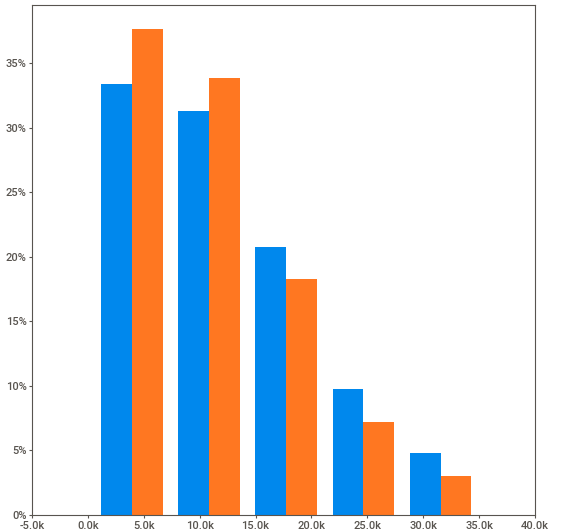
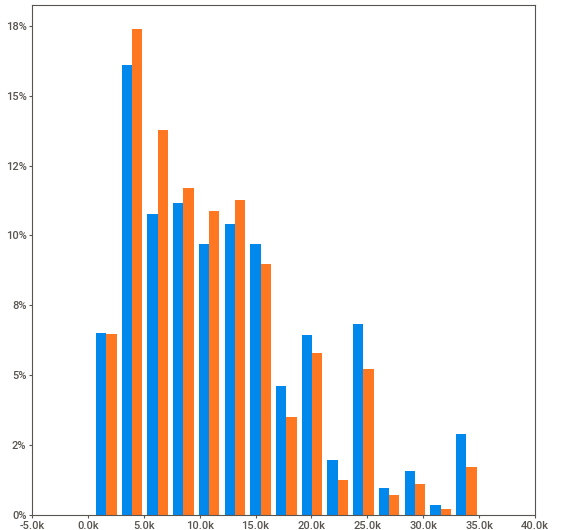
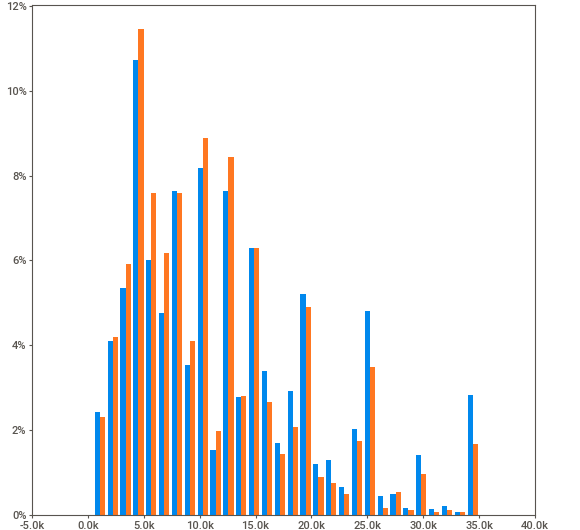
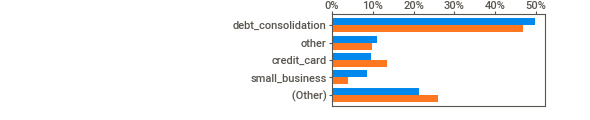
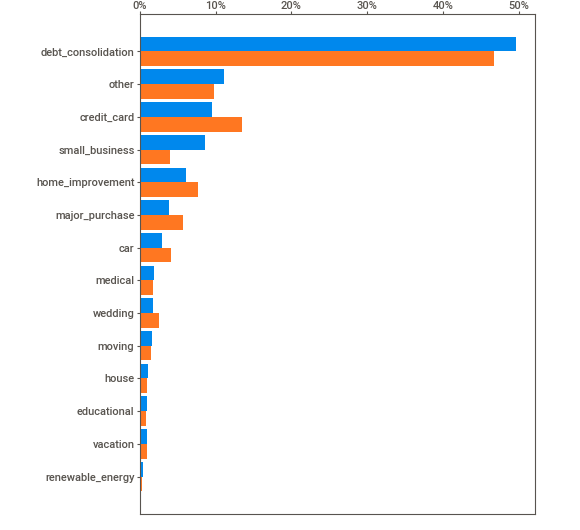
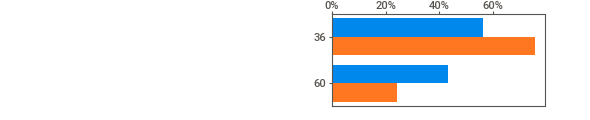
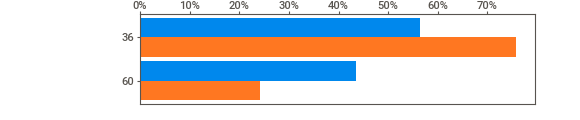
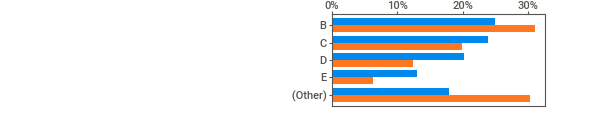
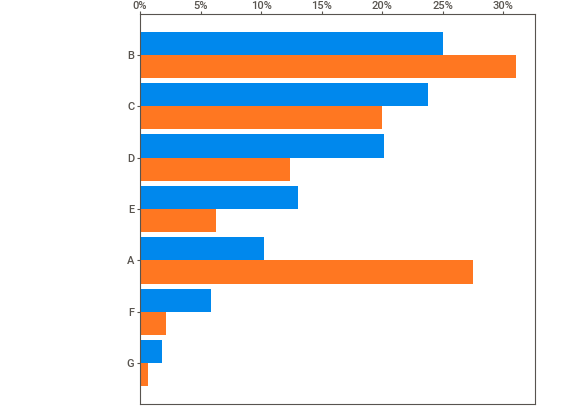
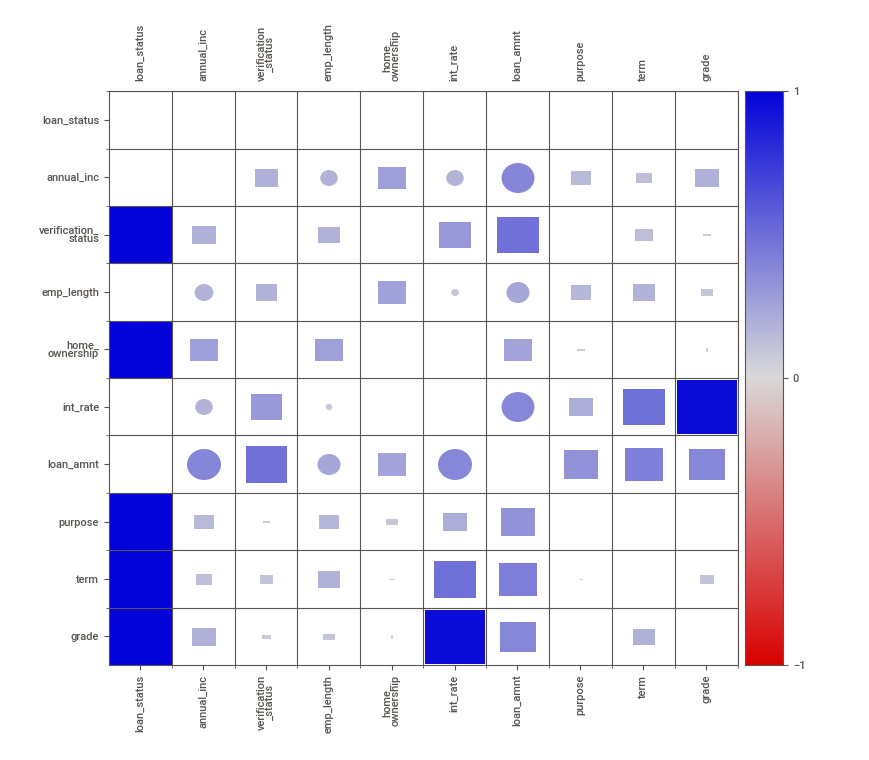
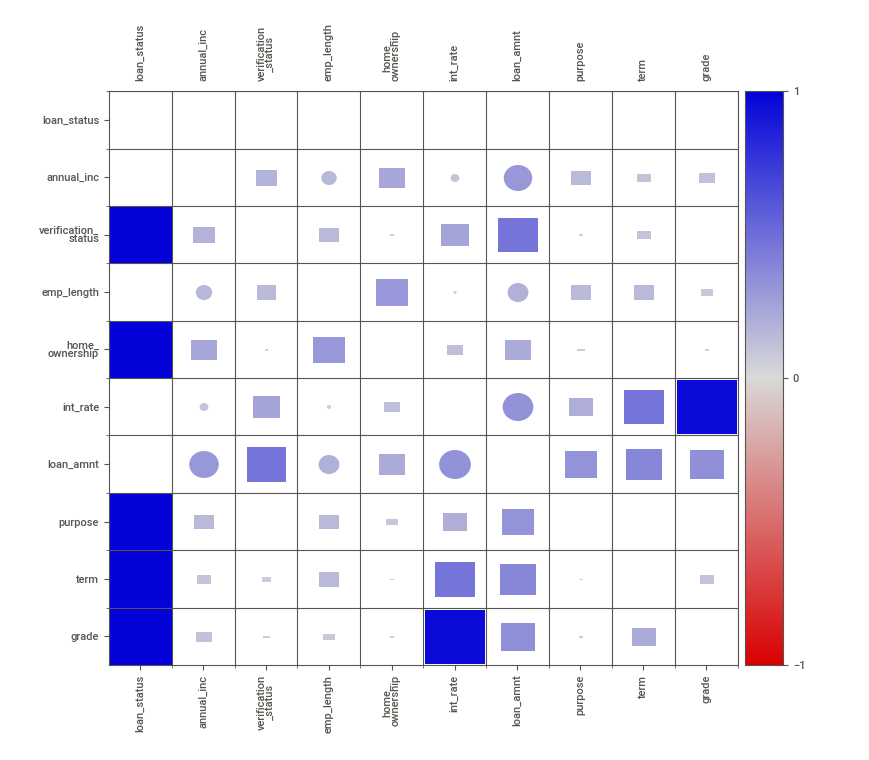

In [14]:
from IPython.display import HTML
reporte.show_html()
HTML('SWEETVIZ_REPORT.html')

## **Problema 2**

1. Convierta las variables `grade` y `verification_status` en tipo numérico Ayuda: utilice df.grade.cat.codes o df.grade.replace({'A':0, 'B':1, <ETC>}).
2. Tome las variables numéricas con sesgo y transfórmelas para que sean más simétricas.

In [17]:
df['grade_codes'] = df.grade.cat.codes # Se puede generar codigos para cada categoria en la variable
map_verfication_status = {'Not Verified': -1, 'Source Verified': 0, 'Verified': 1} # Tambien se puede realizar de esta forma
                                                                                    # Siendo mas especifico
df['verification_status_codes'] = df.verification_status.replace(map_verfication_status) # se le pasa el objeto dict anterior

In [18]:
var_target = ['loan_status']  # Se define la Variable objetivo
var_cat = ['home_ownership', 'purpose'] # Se define variables categoricas.
var_num = ['annual_inc', 'emp_length', 'int_rate','loan_amnt', 'term'] # Variables numericas
var_cat_ord = ['verification_status_codes', 'grade_codes'] # Categoricas ordinales

# Cuando se suman listas el resultado es la concatenación de las listas
var_cat + var_num + var_target

['home_ownership',
 'purpose',
 'annual_inc',
 'emp_length',
 'int_rate',
 'loan_amnt',
 'term',
 'loan_status']

In [19]:
df[var_cat + var_num + var_target]

,home_ownership,purpose,annual_inc,emp_length,int_rate,loan_amnt,term,loan_status
0,RENT,credit_card,24000.0,11,10.65,5000,36,Fully Paid
1,RENT,car,30000.0,0,15.27,2500,60,Charged Off
2,RENT,small_business,12252.0,11,15.96,2400,36,Fully Paid
3,RENT,other,49200.0,11,13.49,10000,36,Fully Paid
4,RENT,other,80000.0,1,12.69,3000,60,Fully Paid
...,...,...,...,...,...,...,...,...
38700,MORTGAGE,home_improvement,110000.0,4,8.07,2500,36,Fully Paid
38701,RENT,credit_card,18000.0,3,10.28,8500,36,Fully Paid
38702,MORTGAGE,debt_consolidation,100000.0,0,8.07,5000,36,Fully Paid
38703,MORTGAGE,other,200000.0,0,7.43,5000,36,Fully Paid


## **05 - Parte 2:** Modelación

### Balanceo de clases

Es un proceso estándar para balancear las clases:

1. Submuestreo. Eliminar datos de la clase dominante
2. Sobremuestreo. Generar datos aleatorios en la clase no dominante.
3. Balanceo función de costo. Modificar la función de costo para dar prioridad a malas clasificaciones de la clase no dominante.

In [20]:
# Se toman las variables numericas
var_num = ['int_rate', 'annual_inc', 'loan_amnt']

# Y se pegan a las variables categoricas
var_select = var_num + var_cat
# TODO: incluir emp_length

# Se define Xy como la matriz completa
Xy = df[var_select + var_target]

# Se separa la tabla en dos partes, los que pagan y los que no
Xy_fully_paid = Xy[Xy.loan_status == 'Fully Paid']
Xy_charged_off = Xy[Xy.loan_status == 'Charged Off']

# Se toman los indices de la clase dominante
index_random = list(np.random.choice(Xy_fully_paid.index, size=5440, replace=False) )

# Se toman los demás índices
index_diff = list(set(Xy_fully_paid.index) - set(index_random))

# Se crean dos tablas: a y b. La tabla a tiene los usuarios de la muestra. La tabla b tiene lo demás
a = Xy_fully_paid.loc[index_random]
b = Xy_fully_paid.loc[index_diff]

# Ahora balanceo
Xy_balanced = pd.concat([a, Xy_charged_off])

# Separo por entrada y salida
X = Xy_balanced[var_select]
y = Xy_balanced[var_target]

<AxesSubplot:xlabel='loan_status'>

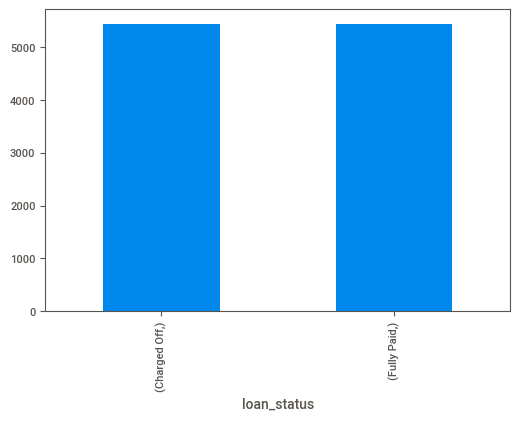

In [21]:
y.value_counts().plot.bar()

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Preprocesamiento

In [26]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Preprocesamiento para alistar los datos
preproc = ColumnTransformer([('dummy', OneHotEncoder(drop='first'), var_cat),
                            #  ('log10', FunctionTransformer(np.log10), var_num),
                            #  ('imputer', SimpleImputer(strategy='mean'), var_num),
                             ('std', StandardScaler(), var_num)])

# preproc(df[var_num])

['home_ownership', 'purpose']

In [27]:
from sklearn.linear_model import LogisticRegression

# paso 1: Defino modelo
modelo_log = Pipeline([
                       ('preprocesamiento', preproc),
                       ('modelo_log', LogisticRegression())
])


# paso 2: Ajusto modelo
modelo_log.fit(X_train, y_train)

# paso 3: Pronostico
y_pred = modelo_log.predict(X_test)

C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


              precision    recall  f1-score   support

 Charged Off       0.65      0.62      0.63      1091
  Fully Paid       0.63      0.66      0.65      1085

    accuracy                           0.64      2176
   macro avg       0.64      0.64      0.64      2176
weighted avg       0.64      0.64      0.64      2176



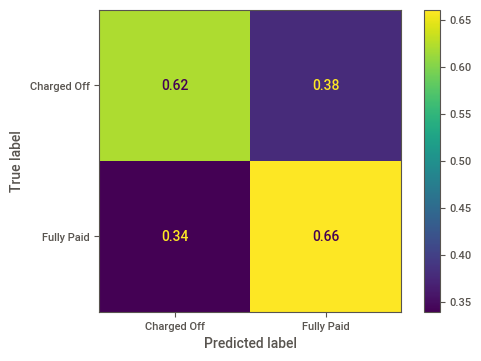

In [28]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
# paso 4: evalúo
print(classification_report(y_test, y_pred))
plot_confusion_matrix(modelo_log, X_test, y_test, normalize = 'true')

### Resultados

* Con variables numéricas: f1-score = 0.63, acc = 0.63
* Con variables numéricas y categóricas: f1-score = 0.63, acc = 0.63

C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

 Charged Off       0.00      0.00      0.00         0
  Fully Paid       1.00      0.64      0.78     27825

    accuracy                           0.64     27825
   macro avg       0.50      0.32      0.39     27825
weighted avg       1.00      0.64      0.78     27825



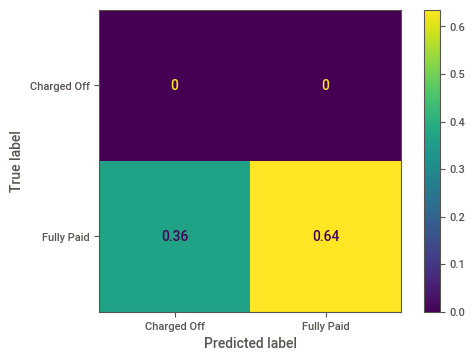

In [29]:
y_pred_b = modelo_log.predict(b[var_select])
print(classification_report(b[var_target], y_pred_b))
plot_confusion_matrix(modelo_log, b[var_select], b[var_target], normalize='true')

**Conclusión**:

El modelo se comporta de la misma manera tanto en los datos de testeo como en los de validación. Es decir, la distribución de datos por fuera del conjunto seleccionado para entrenar y validar el modelo se comportó de la misma manera que el conjunto de datos que nunca se había utilizado antes.

              precision    recall  f1-score   support

 Charged Off       0.57      0.56      0.57      1091
  Fully Paid       0.57      0.58      0.57      1085

    accuracy                           0.57      2176
   macro avg       0.57      0.57      0.57      2176
weighted avg       0.57      0.57      0.57      2176



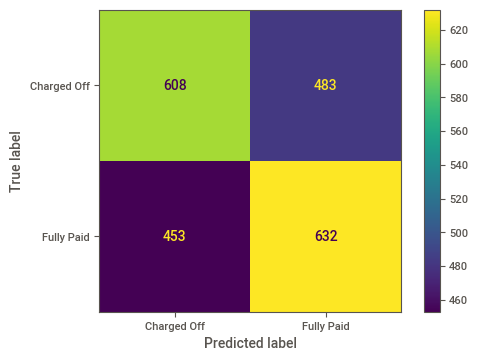

In [30]:
from sklearn.tree import DecisionTreeClassifier

# paso 1: Defino modelo
modelo_dtc = Pipeline([
                       ('preprocesamiento', preproc),
                       ('modelo_dtc', DecisionTreeClassifier(random_state=0))
])

# paso 2: Ajusto modelo
modelo_dtc.fit(X_train, y_train)

# paso 3: Pronostico
y_pred = modelo_dtc.predict(X_test)

# paso 4: evaluar
print(classification_report(y_test, y_pred))
plot_confusion_matrix(modelo_dtc, X_test, y_test)

## Reutilizando código

C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
C:\Users\GAMER\anaconda3\envs\dataAnalyst\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

 Charged Off       0.62      0.65      0.63      1091
  Fully Paid       0.63      0.59      0.61      1085

    accuracy                           0.62      2176
   macro avg       0.62      0.62      0.62      2176
weighted avg       0.62      0.62      0.62      2176



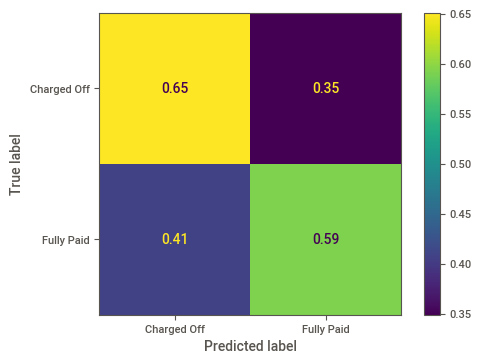

In [31]:
def modelacion(var_num, var_cat=[], var_ord=[]):

    var_select = var_num + var_cat + var_ord

    Xy = df[var_select + var_target]

    Xy_fully_paid = Xy[Xy.loan_status == 'Fully Paid']
    Xy_charged_off = Xy[Xy.loan_status == 'Charged Off']

    index_random = list(np.random.choice(Xy_fully_paid.index, size=5440, replace=False) )
    index_diff = list(set(Xy_fully_paid.index) - set(index_random))
    a = Xy_fully_paid.loc[index_random]
    b = Xy_fully_paid.loc[index_diff]

    Xy_balanced = pd.concat([a, Xy_charged_off])

    X = Xy_balanced[var_select]
    y = Xy_balanced[var_target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


      # Preprocesamiento para alistar los datos

    list_transform = [('log10', FunctionTransformer(np.log10), var_num),
                        ('std', StandardScaler(), var_num)]

    if var_cat: list_transform.append(('dummy', OneHotEncoder(drop='first'), var_cat))

    preproc = ColumnTransformer(list_transform)

      # paso 1: Defino modelo
    modelo_log = Pipeline([
                            ('preprocesamiento', preproc),
                            ('modelo_log', LogisticRegression())
      ])


      # paso 2: Ajusto modelo
    modelo_log.fit(X_train, y_train)

      # paso 3: Pronostico
    y_pred = modelo_log.predict(X_test)

      # paso 4: evalúo
    print(classification_report(y_test, y_pred))
    plot_confusion_matrix(modelo_log, X_test, y_test, normalize = 'true')


var_num = ['int_rate', 'annual_inc', 'loan_amnt']
modelacion(var_num, var_cat, var_cat_ord)

Las variables ordinales parece que no aportan información nueva al modelo de regresión logístico.

## Problema 3

1. Implementar variables categóricas ordinales en el pipeline.
1. Consultar como se convierte las variables categóricas en [dummy](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html#sklearn.preprocessing.OneHotEncoder) e implementarlas en el tunel (pipeline). La función admite el parámetro `drop`, ¿qué significa `drop=first`?
1.  Probar otros modelos: [máquina de soporte vectorial](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html), [naive bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html). ¿Cuál es el mejor de todos?
1. ¿Qué es un modelo de ensamble?

In [33]:
from sklearn.naive_bayes import GaussianNB

# paso 1: Defino modelo
modelo_gnb = Pipeline([
                       ('preprocesamiento', preproc),
                       ('modelo_gnb', GaussianNB())
])


# paso 2: Ajusto modelo
modelo_gnb.fit(X_train, y_train)

# paso 3: Pronostico
y_pred = modelo_gnb.predict(X_test)

# paso 4: evaluar
print(classification_report(y_test, y_pred))
plot_confusion_matrix(modelo_gnb, X_test, y_test, normalize='true')

AttributeError: 'DataFrame' object has no attribute 'toarray'

In [ ]:
from sklearn.svm import SVC

# paso 1: Defino modelo
modelo_svc = Pipeline([
                       ('preprocesamiento', preproc),
                       ('modelo_svc', SVC())
])


# paso 2: Ajusto modelo
modelo_svc.fit(X_train, y_train)

# paso 3: Pronostico
y_pred = modelo_svc.predict(X_test)

# paso 4: evaluar
print(classification_report(y_test, y_pred))
plot_confusion_matrix(modelo_svc, X_test, y_test, normalize='true')

In [ ]:
from sklearn.metrics import plot_roc_curve

ax = plot_roc_curve(modelo_log, X_test, y_test, label = 'log')
plot_roc_curve(modelo_dtc, X_test, y_test, ax=ax.ax_, label = 'dtc')
plot_roc_curve(modelo_gnb, X_test, y_test, ax=ax.ax_, label = 'gnb')
plot_roc_curve(modelo_svc, X_test, y_test, ax=ax.ax_, label = 'svc')

In [ ]:
from sklearn.metrics import plot_roc_curve

ax = plot_roc_curve(modelo_log, X_test, y_test,)
plot_roc_curve(modelo_dtc, X_test, y_test, ax=ax.ax_,)
plot_roc_curve(modelo_gnb, X_test, y_test, ax=ax.ax_,)
plot_roc_curve(modelo_svc, X_test, y_test, ax=ax.ax_,)

## Conclusiones

El modelo logístico y la máquina de soporte vectorial son los mejores modelos y tienen comportamiento muy similar en la curva ROC. 

El modelo definitivo es la regresión logística, porque es un modelo más fácil de interpretar. Esto con una base de datos balanceada. Sin esto la regresión logística no da buenos resultados.



In [ ]:
coefs = modelo_log.named_steps['modelo_log'].coef_
coefs

In [ ]:
coefs.shape # 3 num + 16 cat + 2 ord + 1 interc

## Interpretación del árbol de decisión

El paquete [graphviz](https://scikit-learn.org/stable/modules/tree.html?highlight=graphviz) permite una visualización del árbol de decisión

In [ ]:
from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        modelo_dtc.named_steps['modelo_dtc'],
        out_file="tree.png",
        rounded=True,
        class_names=['moroso', 'no moroso'],
        filled=True
    )

Source.from_file("tree.dot")